In [104]:
!pip install natasha
!pip install Wikipedia-API
!pip install wikipedia
!python -m spacy download ru_core_news_sm
!pip install datefinder
!pip install datasets
!pip install seqeval

2023-10-29 04:27:15.189380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 04:27:15.189450: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 04:27:15.189491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 04:27:15.199979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 04:27:16.576786: W tensorflow/compiler/

In [105]:
from natasha import (Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, NewsSyntaxParser, NewsNERTagger, PER, NamesExtractor, DatesExtractor, MoneyExtractor, AddrExtractor, Doc)
import wikipediaapi
import wikipedia
import re
import datefinder
from razdel import tokenize

In [106]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)
data_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
address_extractor = AddrExtractor(morph_vocab)

#1000 –∏ 1 —Ñ—É–Ω–∫—Ü–∏—è

–∞–∫—Ç–∏–≤–Ω—ã–µ —Ñ—É–Ω–∫—Ü–∏–∏

In [107]:
#–∏—â–µ—Ç –ª–æ–∫–∞—Ü–∏—é, –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—é –∏–ª–∏ –∏–º—è
def exctract_NER(title):
  doc=Doc(title)
  #—Ä–∞–∑–±–∏–≤–∫–∞ —Ç–µ–∫—Å—Ç–∞ –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  doc.tag_ner(ner_tagger)

  #for word in doc.tokens:
  #  word.lemmatize(morph_vocab)


  return [[x.text, replace_NER_name(x.type), x.__dict__['start']] for x in doc.spans]

In [108]:
def replace_NER_name(ner_type):
  replace_dict={'LOC':'–ª–æ–∫–∞—Ü–∏—è','PER':'–ø–µ—Ä—Å–æ–Ω–∞','ORG':'–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è'}
  return replace_dict[ner_type]

In [109]:
#—É–¥–∞–ª—è–µ—Ç –≤—Å–µ —Å—Å—ã–ª–∫–∏ –∏–∑ —Ç–µ–∫—Å—Ç–∞
def delete_links(text):
  pattern = r'<LINK>.*?<LINK>'
  match_=re.findall(pattern, text)
  #print(match_.start(),match_.end())
  text=text[:match_.start()]+'_'*(match_.end()-match_.start())+text[match_.end():]
  #cleaned_text = re.sub(pattern, '', text)
  return text

"""
def delete_links2(text):
  pattern = r'<LINK>.*?<LINK>'
  tag_text=re.sub(pattern,'<DEL LINK>' ,text)
  text_in_links = re.findall(pattern, text)
  tokineze_text_in_links=[]
  for txt in text_in_links:
    raw_toks = list(tokenize(txt))
    words = [tok.text for tok in raw_toks]
    fill_words = ' _'*len(words)
    tokineze_text_in_links.append(fill_words)

  for word_fill_tokens in tokineze_text_in_links:
    tag_text=tag_text.replace('<DEL LINK>',word_fill_tokens,1)

  return tag_text
"""

def delete_tags(text):
  cleaned_text=text.replace('<–ù–ê–ó–í–ê–ù–ò–ï:>',"_"*len('<–ù–ê–ó–í–ê–ù–ò–ï:>')).replace('<–û–ü–ò–°–ê–ù–ò–ï:>',"_"*len('<–û–ü–ò–°–ê–ù–ò–ï:>'))
  return cleaned_text

In [110]:
def clear_text(text):
 try: text=delete_links(text)
 except: pass
 text=delete_tags(text)

 #cleaned_text = re.sub(r'[^-–∞-—è–ê-–Øa-zA-Z.,/ ]', '', re.sub(r'\([^)]*\)|\{[^}]*\}|\[[^\]]*\]', '', text))
 return text

In [111]:
def exctract_date(text):
  pattern_with_dot = r'\b((\d{1,2}\.\d{1,2}\.\d{4})|(\d{1,2} (?:—Å–µ–Ω—Ç—è–±—Ä—è|–æ–∫—Ç—è–±—Ä—è|–Ω–æ—è–±—Ä—è|–¥–µ–∫–∞–±—Ä—è|—è–Ω–≤–∞—Ä—è|—Ñ–µ–≤—Ä–∞–ª—è|–º–∞—Ä—Ç–∞|–∞–ø—Ä–µ–ª—è|–º–∞—è|–∏—é–Ω—è|–∏—é–ª—è|–∞–≤–≥—É—Å—Ç–∞) \d{4}))\b'
  matches = re.findall(pattern_with_dot, text)
  list_data =[]
  if not matches: return list_data
  for match in matches:
    list_data.append([match[0], '–î–∞—Ç–∞', text.find(match[0])])
  return list_data

In [112]:
import re
def find_seazon(text):
  pattern_with_dot = r'((\d+ —Å–µ–∑–æ–Ω)|(—Å–µ–∑–æ–Ω \d+))'
  matches = re.findall(pattern_with_dot, text)
  list_seazon = []
  if not matches:
      return list_seazon
  for match in matches:
    list_seazon.append([match[0], '—Å–µ–∑–æ–Ω', text.find(match[0])])
  return list_seazon

In [113]:
def find_epizode(text):
    pattern_with_dot = r'((—Å–µ—Ä–∏—è \d+)|(\d+ —Å–µ—Ä–∏—è)|(# ?\d+)|(‚Ññ ?\d+))'
    s = text.find("—Å–µ—Ä–∏—è")
    text = text[s:]
    prob = " "
    prob = prob * s
    text = prob + text
    matches = re.findall(pattern_with_dot, text)
    list_epizode = []
    if not matches:
        return list_epizode
    for match in matches:
      list_epizode.append([match[0], '—Å–µ—Ä–∏—è', text.find(match[0])])
    return list_epizode

In [114]:
def extract_epizode_season(text):
  list_seazon = find_seazon(text)
  list_epizode = find_epizode(text)
  list_epizode_seria = []
  for seazon in list_seazon:
    list_epizode_seria.append(seazon)

  for epizode in list_epizode:
    list_epizode_seria.append(epizode)
  return list_epizode_seria



In [30]:
def split_title_discription(text):
  idx=text.find('<–û–ü–ò–°–ê–ù–ò–ï:>')
  title=text[:idx]
  discription=text[idx:]
  return [title, discription]

In [31]:

sport_list=['—Ñ—É—Ç–±–æ–ª','–±–∞—Å–∫–µ—Ç–±–æ–ª','—Ç–µ–Ω–Ω–∏—Å','–≤–æ–ª–µ–π–±–æ–ª','–±–µ–π—Å–±–æ–ª','–≥–∞–Ω–¥–±–æ–ª','—Ö–æ–∫–∫–µ–π','–∫—Ä–∏–∫–µ—Ç','—Ä–µ–≥–±–∏','–∞–º–µ—Ä–∏–∫–∞–Ω—Å–∫–∏–π','—Ñ—É—Ç–±–æ–ª','—Ñ—É—Ç–∑–∞–ª','–Ω–∞—Å—Ç–æ–ª—å–Ω—ã–π','—Ç–µ–Ω–Ω–∏—Å','–∫–∞—Ä–∞—Ç—ç','–±–æ–∫—Å','–±–æ–∫—Å','–±–æ—Ä—å–±–∞','–ø—É–ª–µ–≤–∞—è','—Å—Ç—Ä–µ–ª—å–±–∞','—Å—Ç—Ä–µ–ª—å–±–∞','–∏–∑','–ª—É–∫–∞','–≥–æ–ª—å—Ñ','–≤–µ–ª–æ—Å–ø–æ—Ä—Ç','–ø–ª–∞–≤–∞–Ω–∏–µ','—Å–∏–Ω—Ö—Ä–æ–Ω–Ω–æ–µ','–ø–ª–∞–≤–∞–Ω–∏–µ','–≤–æ–¥–Ω–æ–µ','–ø–æ–ª–æ','–∞–∫–≤–∞–∞—ç—Ä–æ–±–∏–∫–∞','–¥–∞–π–≤–∏–Ω–≥','–≥–∏–º–Ω–∞—Å—Ç–∏–∫–∞','–∞–∫—Ä–æ–±–∞—Ç–∏–∫–∞','—Ç—è–∂–µ–ª–∞—è','–∞—Ç–ª–µ—Ç–∏–∫–∞','–ø–∞—Ä—É—Å–Ω—ã–π','—Å–ø–æ—Ä—Ç','–≤–∏–Ω–¥—Å–µ—Ä—Ñ–∏–Ω–≥','–∫–∞–π—Ç—Å–µ—Ä—Ñ–∏–Ω–≥','–ª–æ–¥–∫–∞','—è—Ö—Ç–∞','—Å—ë—Ä—Ñ–∏–Ω–≥','—Å–∫–µ–π—Ç–±–æ—Ä–¥–∏–Ω–≥','bmx','—Ç—Ä—é–∫–æ–≤–æ–π','—Å–ø–æ—Ä—Ç','—Ç–∞–Ω—Ü—ã','–±–∞–ª–µ—Ç','–ª—ã–∂–∏','–∞–ª—å–ø–∏–Ω–∏–∑–º','—Ç—É—Ä–∏–∑–º','football','basketball','tennis','volleyball','baseball','handball','hockey','cricket','rugby','american','football','futsal','table','tennis','karate','boxing','boxing','wrestling','bullet','shooting','archery','golf','cycling','swimming','synchronized','swimming','water','polo','water','aerobics','diving','gymnastics','acrobatics','weightlifting','sailing','windsurfing','kitesurfing','boat','yacht','surfing','skateboarding','bmx','stunt','sports','dancing','ballet','skiing','mountaineering','hiking']
def exctract_sport(text):
  exctracts=[]
  doc=Doc(text)
  #—Ä–∞–∑–±–∏–≤–∫–∞ —Ç–µ–∫—Å—Ç–∞ –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)

  for word in doc.tokens:
    word.lemmatize(morph_vocab)
    if word.lemma in sport_list:
      exctracts.append([word.text,'–≤–∏–¥ —Å–ø–æ—Ä—Ç–∞',word.start])
  return exctracts

In [32]:
def pipline_afer_exctact(category,analise_dict):
  if len(category)==0: return analise_dict
  for exemplar in category:
    analise_dict['NER'].append(exemplar)
  return analise_dict

In [93]:
#–æ—Å–Ω–æ–≤–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ –∏ –∞–Ω–∞–ª–∏–∑–∞ —Ç–µ–∫—Å—Ç–∞
def full_analise(text):
  analise_dict={}
  title, discription=split_title_discription(text)
  text=clear_text(text)

  #–≤—ã–¥–µ–ª–µ–Ω–∏–µ –ø–µ—Ä—Å–æ–Ω—ã, –ª–æ–∫–∞—Ü–∏–∏, –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏
  analise_dict['NER']=exctract_NER(text)

  #–≤—ã–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ä–∏–∏ –∏ —Å–µ–∑–æ–Ω–∞
  ss=extract_epizode_season(text)
  analise_dict=pipline_afer_exctact(ss,analise_dict)

  #–≤—ã–¥–µ–ª–µ–Ω–∏–µ –¥–∞—Ç—ã
  dates=exctract_date(text)
  analise_dict=pipline_afer_exctact(dates,analise_dict)

  #–≤—ã–¥–µ–ª–µ–Ω–∏–µ –≤–∏–¥–æ–≤ —Å–ø–æ—Ä—Ç–∞
  #sports=exctract_sport(text)
  #analise_dict=pipline_afer_exctact(sports,analise_dict)

  return analise_dict


In [34]:
#–ø—Ä–∏–≤–æ–¥ –Ω–∞—à–µ–≥–æ —Ñ–æ—Ä–º–∞—Ç–∞ –≤—ã–¥–µ–ª–µ–Ω–∏—è NER –≤ —Ñ–æ—Ä–º–∞—Ç –¥–∞—Ç–∞—Å–µ—Ç–∞
def full_analise_dForm(text):
  analise_dict=full_analise(text)
  if len(analise_dict['NER'])==0: return {'label':'–Ω–µ –Ω–∞–π–¥–µ–Ω–æ'}
  normal_analise_dicts=[]
  for ner in analise_dict['NER']:
    normal_analise_dict={}
    normal_analise_dict['label']=ner[1]
    normal_analise_dict['offset']=ner[2]
    normal_analise_dict['length']=len(ner[0])
    normal_analise_dict['segment']=ner[0]
    normal_analise_dicts.append(normal_analise_dict)
  return normal_analise_dicts

In [64]:
title="""14 –æ–∫—Ç—è–±—Ä—è 2023 –≥–æ–¥–∞ –Æ—Ä—å–µ–≤ –ù–∏–∫–∏—Ç–∞ –ø–æ—à–µ–ª –≤ —è–Ω–¥–µ–∫—Å, –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –æ–Ω –≤ –†–æ—Å—Å–∏–∏, –≥–æ—Ä–æ–¥ –ú–æ—Å–∫–≤–∞, —Ç–∞–º –ø—Ä–µ–¥—Å—Ç–∞–≤–∏–ª–∏ –Ω–∞–º –Ω–æ–≤—ã–π —Å–µ–∑–æ–Ω –∏ —Å–µ—Ä–∏—é —á–µ–ª–æ–≤–µ–∫–∞ –ø–∞—É–∫–∞"""
discription="–ü—Ä–∏—Å—É—Ç—Å—Ç–≤—É–µ—Ç —Å–ø–æ–π–ª–µ—Ä—ã –∏ –Ω–µ–Ω–æ—Ä–º–∞—Ç–∏–≤–Ω–∞—è –ª–µ–∫—Å–∏–∫–∞. –í —ç—Ç–æ–π –Ω–∞—Ä–µ–∑–∫–µ –≤—ã —É–≤–∏–¥–∏—Ç–µ: –ö–∞–∫ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ø–∞—É—á—å–µ —á—É—Ç—å–µ –≤ Spider-Man, –∫–æ—Å–ø–ª–µ–π –Ω–∞ —á–µ–ª–æ–≤–µ–∫–∞-–ø–∞—É–∫–∞, –º–Ω–µ–Ω–∏–µ –æ–± –∏–≥—Ä–µ –∏ –¥—Ä—É–≥–∏–µ –∑–∞–±–∞–≤–Ω—ã–µ –º–æ–º–µ–Ω—Ç—ã."
text=f"<–ù–ê–ó–í–ê–ù–ò–ï:> {title} <–û–ü–ò–°–ê–ù–ò–ï:> {discription}"

In [67]:
#–ù–∞—à —Ñ–æ—Ä–º–∞—Ç –≤—ã–¥–µ–ª–µ–Ω–∏—è NER
full_analise(text)['NER']

[['–Æ—Ä—å–µ–≤ –ù–∏–∫–∏—Ç–∞', '–ø–µ—Ä—Å–æ–Ω–∞', 33],
 ['–†–æ—Å—Å–∏–∏', '–ª–æ–∫–∞—Ü–∏—è', 77],
 ['–ú–æ—Å–∫–≤–∞', '–ª–æ–∫–∞—Ü–∏—è', 91],
 ['Spider-Man', '–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è', 272],
 ['14 –æ–∫—Ç—è–±—Ä—è 2023', '–î–∞—Ç–∞', 12]]

In [68]:
#–í—ã–¥–µ–ª–µ–Ω–∏–µ NER –≤ —Ñ–æ—Ä–º–∞—Ç–µ –¥–∞—Ç–∞—Å–µ—Ç–∞
full_analise_dForm(text)

[{'label': '–ø–µ—Ä—Å–æ–Ω–∞', 'offset': 33, 'length': 12, 'segment': '–Æ—Ä—å–µ–≤ –ù–∏–∫–∏—Ç–∞'},
 {'label': '–ª–æ–∫–∞—Ü–∏—è', 'offset': 77, 'length': 6, 'segment': '–†–æ—Å—Å–∏–∏'},
 {'label': '–ª–æ–∫–∞—Ü–∏—è', 'offset': 91, 'length': 6, 'segment': '–ú–æ—Å–∫–≤–∞'},
 {'label': '–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è',
  'offset': 272,
  'length': 10,
  'segment': 'Spider-Man'},
 {'label': '–î–∞—Ç–∞', 'offset': 12, 'length': 15, 'segment': '14 –æ–∫—Ç—è–±—Ä—è 2023'}]

#<h1>–ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞</h1>

In [69]:
import pandas as pd
from matplotlib import pyplot as plt

In [115]:
dataframe=pd.read_csv('./ner_data_train.csv')

In [116]:
dataframe

video_info  \
0     <–ù–ê–ó–í–ê–ù–ò–ï:> –ê–≥–µ–Ω—Ç 117: –ò–∑ –ê—Ñ—Ä–∏–∫–∏ —Å –ª—é–±–æ–≤—å—é ‚Äî –†—É—Å—Å–∫–∏–π —Ç–∏–∑–µ—Ä=—Ç—Ä–µ–π–ª–µ—Ä (2021) <–û–ü–ò–°–ê–ù–ò–ï:>–õ—É—á—à–∏–π Telegram –∫–∞–Ω–∞–ª –æ –∫–∏–Ω–æ <LINK> –°–æ—Ç—Ä—É–¥–Ω–∏—á–µ—Å—Ç–≤–æ <LINK> –î–∞—Ç–∞ –≤—ã—Ö–æ–¥–∞ 26 –∞–≤–≥—É—Å—Ç–∞ 2021 –û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ –Ω–∞–∑–≤–∞–Ω–∏–µ: OSS 117: Alerte rouge en Afrique noire –°—Ç—Ä–∞–Ω–∞: –§—Ä–∞–Ω—Ü–∏—è –†–µ–∂–∏—Å—Å–µ—Ä: –ù–∏–∫–æ–ª—è –ë–µ–¥–æ—Å –ñ–∞–Ω—Ä: –±–æ–µ–≤–∏–∫, –∫–æ–º–µ–¥–∏—è –í ...   
1     <–ù–ê–ó–í–ê–ù–ò–ï:> –ö–æ–ª–µ–Ω–≤–∞–ª –ò–Ω—Ñ–∏–Ω–∏—Ç–∏ –ö—É –∏–∫—Å 56= 5.6 VK56 VK56DE VK56=DE –ö–æ–ª–µ–Ω–Ω—ã–π –í–∞–ª Infiniti QX56= 5.6 —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–π <–û–ü–ò–°–ê–ù–ò–ï:><LINK> kolenval infiniti iks.html –ö–æ–ª–µ–Ω–≤–∞–ª –ò–Ω—Ñ–∏–Ω–∏—Ç–∏ –ö—É –∏–∫—Å 56‚Äã –ö–æ–ª–µ–Ω–Ω—ã–π –í–∞–ª Infiniti QX56‚Äã –ú–æ–¥–µ–ª—å –î–≤–∏–≥–∞—Ç–µ–ª—è: VK56, VK56DE, VK56 DE –†–∞–±–æ—á–∏–π –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è: 5.6 –ú–æ—â–Ω–æ—Å—Ç—å –≤ –ª.—Å. ...   
2     <–ù–ê–ó–í–ê–ù–ò–ï:> –í–´–ó–û–í –î–ï–ú–û–ù–ê = –í—ã–∑–≤–∞–ª –°–µ—Ä–æ–≥–æ –ß–µ–ª–æ–≤–µ–∫–∞ [–ö–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π —Ñ–∏–ª—å–º] #—Å–µ—Ä—ã–π—á–µ–ª–æ–≤–µ–∫, #–∫–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π—Ñ–∏–ª—å–º <–û–ü–ò–°–ê–ù–ò–ï:>–í–´–ó–û–í –î–ï–ú–û–ù–ê –í—ã–∑–≤–∞–ª –°–µ—Ä–æ–≥–æ –ß–µ–ª–æ–≤–µ–∫–∞ [–ö–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π —Ñ–∏–ª—å–º] #—Å–µ—Ä—ã–π—á–µ–ª–æ–≤–µ–∫, #–∫–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π—Ñ–∏–ª—å–º –°–ø–∞—Å–∏–±–æ –∑–∞ –ø—Ä–æ—Å–º–æ—Ç—Ä. –í –∫–∞—á–µ—Å—Ç–≤–µ –æ–ø–ª–∞—Ç—ã —Å –≤–∞—Å –ª–∞–π–∫ –∏ –ø–æ–¥–ø–∏—Å–∫–∞) –°—Å—ã–ª–∫–∏ –Ω–∞ –º...   
3     <–ù–ê–ó–í–ê–ù–ò–ï:> –î–æ–≤–æ–µ–Ω–Ω–∞—è –Ω–µ–º–µ—Ü–∫–∞—è –∫–∏—Ä—Ö–∞ –≤ –ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏. –ü–æ—Å–µ—Ç–∏–ª–∏ –≤–º–µ—Å—Ç–µ —Å #–ó–∞–±—Ä–æ—à–∫–∏39! <–û–ü–ò–°–ê–ù–ò–ï:>–•–æ—á–µ—à—å –Ω–æ–≤—ã—Ö —ç–º–æ—Ü–∏–π, –ø–æ–±—ã–≤–∞—Ç—å –≤ –Ω–µ–æ–±—ã—á–Ω—ã—Ö –º–µ—Å—Ç–∞—Ö, —Ç–æ–≥–¥–∞ –ø—Ä–∏—Å–æ–µ–¥–∏–Ω—è–π—Å—è –∫ –Ω–∞–º <AT>! –ê–≤—Ç–æ–º–æ–±–∏–ª—å–Ω—ã–µ –ø—É—Ç–µ—à–µ—Å—Ç–≤–∏—è –ø–æ –∑–∞–±—Ä–æ—à–µ–Ω–Ω—ã–º —Å—Ç–∞—Ä–∏–Ω–Ω—ã–º —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è–º. –°–∞–º—ã–µ –Ω–µ–æ–±—ã—á–Ω—ã–µ –º–µ—Å—Ç–∞ –ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç...   
4     <–ù–ê–ó–í–ê–ù–ò–ï:> "–°–ø–∞—Ä—Ç–∞–∫—É" –ø–æ–º–æ–≥–ª–∏ —Å—É–¥—å–∏? –õ–æ–∫–æ–º–æ—Ç–∏–≤ –∑–∞—Å—É–¥–∏–ª–∏? –°—Ç–æ–∏–ª–æ –ª–∏ –æ—Ç–º–µ–Ω—è—Ç—å –≥–æ–ª? <–û–ü–ò–°–ê–ù–ò–ï:>–°–ø–∞—Ä—Ç–∞–∫ #–õ–æ–∫–æ–º–æ—Ç–∏–≤ #–æ–±–∑–æ—Ä #–æ–±–∑–æ—Ä–º–∞—Ç—á–∞ #–≤—Å–µ–≥–æ–ª—ã #–õ–æ–∫–æ #–õ–æ–∫–æ–º–æ—Ç–∏–≤–ú–æ—Å–∫–≤–∞ #–≥–æ–ª–ü—Ä—É—Ü–µ–≤–∞ #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫–æ–±–∑–æ—Ä #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫–ø–æ–ª–Ω—ã–π–º–∞—Ç—á #–ö—É–±–æ–∫ #–ö—É–±–æ–∫–†–æ—Å—Å–∏–∏ #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫—Å—É–¥—å—è #–æ—Ç–º–µ–Ω–µ–Ω–Ω—ã–π–≥–æ–ª #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø...   
...                                                                                                                                                                                                                                                                                                           ...   
6417  <–ù–ê–ó–í–ê–ù–ò–ï:> –ó–ê–ü–†–ï–©–ï–ù–ù–´–ô –£–î–ê–†! –ü–æ–ª–Ω—ã–π –±–æ–π –í–∞–¥–∏–º –ù–µ–º–∫–æ–≤ vs –ö–æ—Ä–∏ –ê–Ω–¥–µ—Ä—Å–æ–Ω / –û–ë–ó–û–† BELLATOR 277 <–û–ü–ò–°–ê–ù–ò–ï:>‚ñ∫ –†–µ–≥–∏—Å—Ç—Ä–∏—Ä—É–π—Å—è, –ø–æ–ª—É—á–∞–π –§–†–ò–ë–ï–¢ <LINK> ‚ñ∫ –¢–ï–õ–ï–ì–†–ê–ú–ú MMA review <LINK> ‚ñ∫ –ì–†–£–ü–ü–ê VK: <LINK> ‚ñ∫ –Ø–ù–î–ï–ö–° –î–ó–ï–ù: <LINK> –û–ë–ó–û–† BELLATOR 277 –í–∞–¥–∏–º –ù–µ–º–∫–æ–≤ vs –ö–æ—Ä–∏ –ê–Ω–¥–µ—Ä—Å–æ–Ω / –≠–π –î–∂–µ–π –ú–∞–∫–∫–∏, –ü–∞—Ç—Ä–∏—Å–∏–æ –§—Ä–µ–π—Ä–µ ...   
6418  <–ù–ê–ó–í–ê–ù–ò–ï:> –ö–∞–∫ —Å–æ–∑–¥–∞—é—Ç—Å—è –º–µ–¥–∞–ª–∏: –æ–ø—Ç–∏—á–µ—Å–∫–∏–µ –∏–ª–ª—é–∑–∏–∏ –≥–ª—É–±–∏–Ω—ã, –≤—ã—Å–æ—Ç—ã, –æ–±—ä—ë–º–∞ <–û–ü–ò–°–ê–ù–ò–ï:>–•–∞–Ω—Ç—ã–π—Å–∫–∏–π —Ö—É–¥–æ–∂–Ω–∏–∫, –≤—ã—Ä–æ—Å—à–∏–π –Ω–∞ –Ø–º–∞–ª–µ, –±–æ–ª–µ–µ 20 –ª–µ—Ç —Ä–∞–±–æ—Ç–∞–µ—Ç –Ω–∞ –ú–æ—Å–∫–æ–≤—Å–∫–æ–º –º–æ–Ω–µ—Ç–Ω–æ–º –¥–≤–æ—Ä–µ. –ù–æ –°–µ–≤–µ—Ä –¥–ª—è –≠–¥—É–∞—Ä–¥–∞ –¢–æ–ª—å–∑–∏–Ω–∞ ‚Äì –≥–ª–∞–≤–Ω—ã–π –∏—Å—Ç–æ—á–Ω–∏–∫ –≤–¥–æ—Ö–Ω–æ–≤–µ–Ω–∏—è. –°–∫—É–ª—å–ø—Ç–æ—Ä –ø—Ä–∏–≤—ë–∑ –≤ –æ–∫—Ä—É–∂–Ω–æ–π –¥–æ–º —Ä–µ–º—ë—Å–µ–ª –ø–µ—Ä—Å–æ–Ω–∞–ª—å–Ω—É—é –≤...   
6419  <–ù–ê–ó–í–ê–ù–ò–ï:> –†–µ–º–æ–Ω—Ç

In [117]:
dataframe['video_info'][0]

'<–ù–ê–ó–í–ê–ù–ò–ï:> –ê–≥–µ–Ω—Ç 117: –ò–∑ –ê—Ñ—Ä–∏–∫–∏ —Å –ª—é–±–æ–≤—å—é ‚Äî –†—É—Å—Å–∫–∏–π —Ç–∏–∑–µ—Ä=—Ç—Ä–µ–π–ª–µ—Ä (2021) <–û–ü–ò–°–ê–ù–ò–ï:>–õ—É—á—à–∏–π Telegram –∫–∞–Ω–∞–ª –æ –∫–∏–Ω–æ <LINK> –°–æ—Ç—Ä—É–¥–Ω–∏—á–µ—Å—Ç–≤–æ <LINK> –î–∞—Ç–∞ –≤—ã—Ö–æ–¥–∞ 26 –∞–≤–≥—É—Å—Ç–∞ 2021 –û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ –Ω–∞–∑–≤–∞–Ω–∏–µ: OSS 117: Alerte rouge en Afrique noire –°—Ç—Ä–∞–Ω–∞: –§—Ä–∞–Ω—Ü–∏—è –†–µ–∂–∏—Å—Å–µ—Ä: –ù–∏–∫–æ–ª—è –ë–µ–¥–æ—Å –ñ–∞–Ω—Ä: –±–æ–µ–≤–∏–∫, –∫–æ–º–µ–¥–∏—è –í –≥–ª–∞–≤–Ω—ã—Ö —Ä–æ–ª—è—Ö: –ñ–∞–Ω –î—é–∂–∞—Ä–¥–µ–Ω, –ü—å–µ—Ä –ù–∏–Ω—ç, –ú–µ–ª–æ–¥–∏ –ö–∞—Å—Ç–∞, –ù–∞—Ç–∞—à–∞ –õ–∏–Ω–¥–∏–Ω–∂–µ—Ä, –í–ª–∞–¥–∏–º–∏—Ä –ò–æ—Ä–¥–∞–Ω–æ–≤, –§–∞—Ç—É –ù‚Äô–î–∏–∞–π–µ, –ü–æ–ª –£–∞–π—Ç –ú–∏—Ä –∏–∑–º–µ–Ω–∏–ª—Å—è. –û–Ω –Ω–µ—Ç. –°—É–¥—å–±–∞ –∑–∞–Ω–æ—Å–∏—Ç –ª–µ–≥–µ–Ω–¥–∞—Ä–Ω–æ–≥–æ –ê–≥–µ–Ω—Ç–∞ 117 –≤ –ê—Ñ—Ä–∏–∫—É, –≥–¥–µ –≥–æ—Ä—è—á–µ–µ –ø—É—Å—Ç—ã–Ω–∏ —Ç–æ–ª—å–∫–æ –∂–µ–Ω—â–∏–Ω—ã. –í–æ–æ—Ä—É–∂–µ–Ω–Ω—ã–π –Ω–µ–∏—Å—Å—è–∫–∞–µ–º–æ–π —É–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç—å—é –≤ —Å–µ–±–µ –∏ —É–±–∏–π—Å—Ç–≤–µ–Ω–Ω–æ–π —Ö–∞—Ä–∏–∑–º–æ–π

In [118]:
dataframe['entities'][0]

'{"label":"–ª–æ–∫–∞—Ü–∏—è"\\,"offset":26\\,"length":6\\,"segment":"–ê—Ñ—Ä–∏–∫–∏"},{"label":"–î–∞—Ç–∞"\\,"offset":155\\,"length":15\\,"segment":"26 –∞–≤–≥—É—Å—Ç–∞ 2021"},{"label":"–Ω–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞"\\,"offset":194\\,"length":38\\,"segment":"OSS 117: Alerte rouge en Afrique noire"},{"label":"–ª–æ–∫–∞—Ü–∏—è"\\,"offset":241\\,"length":7\\,"segment":"–§—Ä–∞–Ω—Ü–∏—è"},{"label":"–ø–µ—Ä—Å–æ–Ω–∞"\\,"offset":259\\,"length":12\\,"segment":"–ù–∏–∫–æ–ª—è –ë–µ–¥–æ—Å"},{"label":"–ø–µ—Ä—Å–æ–Ω–∞"\\,"offset":311\\,"length":12\\,"segment":"–ñ–∞–Ω –î—é–∂–∞—Ä–¥–µ–Ω"},{"label":"–ø–µ—Ä—Å–æ–Ω–∞"\\,"offset":325\\,"length":9\\,"segment":"–ü—å–µ—Ä –ù–∏–Ω—ç"},{"label":"–ø–µ—Ä—Å–æ–Ω–∞"\\,"offset":336\\,"length":12\\,"segment":"–ú–µ–ª–æ–¥–∏ –ö–∞—Å—Ç–∞"},{"label":"–ø–µ—Ä—Å–æ–Ω–∞"\\,"offset":350\\,"length":16\\,"segment":"–ù–∞—Ç–∞—à–∞ –õ–∏–Ω–¥–∏–Ω–∂–µ—Ä"},{"label":"–ø–µ—Ä—Å–æ–Ω–∞"\\,"offset":368\\,"length":17\\,"segment":"–í–ª–∞–¥–∏–º–∏—Ä –ò–æ—Ä–¥–∞–Ω–æ–≤"},{"label":"–ø–µ—Ä—Å–æ–Ω–∞"\\,"offset":387\\,"le

In [119]:
def cut_vidio_text(vidio_text):
  idx=vidio_text.find('<–û–ü–ò–°–ê–ù–ò–ï:>')
  return vidio_text[:idx].replace('<–ù–ê–ó–í–ê–ù–ò–ï:>','')

In [120]:
def normalise_dataset(dataframe):
  norm_dataset=[]
  #—Ä–∞–∑–±–∏–≤–∫–∞ –Ω–∞ –≤–∏–¥–µ–æ
  for title,video in zip(dataframe['video_info'],dataframe['entities']):
    labels=video.split('},{')
    norm_signs=[]
    #—Ä–∞–∑–±–∏–≤–∫–∞ –Ω–∞ –∫–∞–∂–¥—ã–π –Ω–∞–π–¥–µ–Ω–Ω—ã–π NER —ç–ª–µ–º–µ–Ω—Ç
    for label_str in labels:
      sign_dict={}
      label=label_str.replace('{','').replace('}','').replace('\\','').split(',"')
      # —Ä–∞–∑–±–∏–≤–∫–∞ –Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–∏ –Ω–∞—Ü–¥–µ–Ω–Ω–æ–≥–æ NER —ç–ª–µ–º–µ–Ω—Ç–∞
      for sign in label:
        keyVal=sign.split(':')
        if len(keyVal)!=2: break
        sign_dict[keyVal[0].replace('"','').replace("'",'')]=keyVal[1].replace('"','').replace("'",'')
        #print(sign_dict)
      else:
        norm_signs.append(sign_dict)
    if len(norm_signs)==0: continue
    norm_dataset.append([title,norm_signs])
  return norm_dataset

In [121]:
def exctract_dataset_statistics(dataframe):
  exctract_labels=[]
  #—Ä–∞–∑–±–∏–≤–∫–∞ –Ω–∞ –≤–∏–¥–µ–æ
  for title,video in zip(dataframe['video_info'],dataframe['entities']):
    labels=video.split('},{')
    #—Ä–∞–∑–±–∏–≤–∫–∞ –Ω–∞ –∫–∞–∂–¥—ã–π –Ω–∞–π–¥–µ–Ω–Ω—ã–π NER —ç–ª–µ–º–µ–Ω—Ç
    for label_str in labels:
      label=label_str.replace('{','').replace('}','').replace('\\','').split(',"')
      # —Ä–∞–∑–±–∏–≤–∫–∞ –Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–∏ –Ω–∞—Ü–¥–µ–Ω–Ω–æ–≥–æ NER —ç–ª–µ–º–µ–Ω—Ç–∞
      for sign in label:
        keyVal=sign.split(':')
        if len(keyVal)!=2: break
        if keyVal[0].replace('"','').replace("'",'')=='label':
          exctract_labels.append(keyVal[1].replace('"','').replace("'",''))

  return exctract_labels

In [122]:
df = pd.DataFrame(normalise_dataset(dataframe),columns=['video_info','entities'])

In [123]:
df

video_info  \
0     <–ù–ê–ó–í–ê–ù–ò–ï:> –ê–≥–µ–Ω—Ç 117: –ò–∑ –ê—Ñ—Ä–∏–∫–∏ —Å –ª—é–±–æ–≤—å—é ‚Äî –†—É—Å—Å–∫–∏–π —Ç–∏–∑–µ—Ä=—Ç—Ä–µ–π–ª–µ—Ä (2021) <–û–ü–ò–°–ê–ù–ò–ï:>–õ—É—á—à–∏–π Telegram –∫–∞–Ω–∞–ª –æ –∫–∏–Ω–æ <LINK> –°–æ—Ç—Ä—É–¥–Ω–∏—á–µ—Å—Ç–≤–æ <LINK> –î–∞—Ç–∞ –≤—ã—Ö–æ–¥–∞ 26 –∞–≤–≥—É—Å—Ç–∞ 2021 –û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ –Ω–∞–∑–≤–∞–Ω–∏–µ: OSS 117: Alerte rouge en Afrique noire –°—Ç—Ä–∞–Ω–∞: –§—Ä–∞–Ω—Ü–∏—è –†–µ–∂–∏—Å—Å–µ—Ä: –ù–∏–∫–æ–ª—è –ë–µ–¥–æ—Å –ñ–∞–Ω—Ä: –±–æ–µ–≤–∏–∫, –∫–æ–º–µ–¥–∏—è –í ...   
1     <–ù–ê–ó–í–ê–ù–ò–ï:> –ö–æ–ª–µ–Ω–≤–∞–ª –ò–Ω—Ñ–∏–Ω–∏—Ç–∏ –ö—É –∏–∫—Å 56= 5.6 VK56 VK56DE VK56=DE –ö–æ–ª–µ–Ω–Ω—ã–π –í–∞–ª Infiniti QX56= 5.6 —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–π <–û–ü–ò–°–ê–ù–ò–ï:><LINK> kolenval infiniti iks.html –ö–æ–ª–µ–Ω–≤–∞–ª –ò–Ω—Ñ–∏–Ω–∏—Ç–∏ –ö—É –∏–∫—Å 56‚Äã –ö–æ–ª–µ–Ω–Ω—ã–π –í–∞–ª Infiniti QX56‚Äã –ú–æ–¥–µ–ª—å –î–≤–∏–≥–∞—Ç–µ–ª—è: VK56, VK56DE, VK56 DE –†–∞–±–æ—á–∏–π –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è: 5.6 –ú–æ—â–Ω–æ—Å—Ç—å –≤ –ª.—Å. ...   
2     <–ù–ê–ó–í–ê–ù–ò–ï:> –í–´–ó–û–í –î–ï–ú–û–ù–ê = –í—ã–∑–≤–∞–ª –°–µ—Ä–æ–≥–æ –ß–µ–ª–æ–≤–µ–∫–∞ [–ö–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π —Ñ–∏–ª—å–º] #—Å–µ—Ä—ã–π—á–µ–ª–æ–≤–µ–∫, #–∫–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π—Ñ–∏–ª—å–º <–û–ü–ò–°–ê–ù–ò–ï:>–í–´–ó–û–í –î–ï–ú–û–ù–ê –í—ã–∑–≤–∞–ª –°–µ—Ä–æ–≥–æ –ß–µ–ª–æ–≤–µ–∫–∞ [–ö–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π —Ñ–∏–ª—å–º] #—Å–µ—Ä—ã–π—á–µ–ª–æ–≤–µ–∫, #–∫–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π—Ñ–∏–ª—å–º –°–ø–∞—Å–∏–±–æ –∑–∞ –ø—Ä–æ—Å–º–æ—Ç—Ä. –í –∫–∞—á–µ—Å—Ç–≤–µ –æ–ø–ª–∞—Ç—ã —Å –≤–∞—Å –ª–∞–π–∫ –∏ –ø–æ–¥–ø–∏—Å–∫–∞) –°—Å—ã–ª–∫–∏ –Ω–∞ –º...   
3     <–ù–ê–ó–í–ê–ù–ò–ï:> –î–æ–≤–æ–µ–Ω–Ω–∞—è –Ω–µ–º–µ—Ü–∫–∞—è –∫–∏—Ä—Ö–∞ –≤ –ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏. –ü–æ—Å–µ—Ç–∏–ª–∏ –≤–º–µ—Å—Ç–µ —Å #–ó–∞–±—Ä–æ—à–∫–∏39! <–û–ü–ò–°–ê–ù–ò–ï:>–•–æ—á–µ—à—å –Ω–æ–≤—ã—Ö —ç–º–æ—Ü–∏–π, –ø–æ–±—ã–≤–∞—Ç—å –≤ –Ω–µ–æ–±—ã—á–Ω—ã—Ö –º–µ—Å—Ç–∞—Ö, —Ç–æ–≥–¥–∞ –ø—Ä–∏—Å–æ–µ–¥–∏–Ω—è–π—Å—è –∫ –Ω–∞–º <AT>! –ê–≤—Ç–æ–º–æ–±–∏–ª—å–Ω—ã–µ –ø—É—Ç–µ—à–µ—Å—Ç–≤–∏—è –ø–æ –∑–∞–±—Ä–æ—à–µ–Ω–Ω—ã–º —Å—Ç–∞—Ä–∏–Ω–Ω—ã–º —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è–º. –°–∞–º—ã–µ –Ω–µ–æ–±—ã—á–Ω—ã–µ –º–µ—Å—Ç–∞ –ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç...   
4     <–ù–ê–ó–í–ê–ù–ò–ï:> "–°–ø–∞—Ä—Ç–∞–∫—É" –ø–æ–º–æ–≥–ª–∏ —Å—É–¥—å–∏? –õ–æ–∫–æ–º–æ—Ç–∏–≤ –∑–∞—Å—É–¥–∏–ª–∏? –°—Ç–æ–∏–ª–æ –ª–∏ –æ—Ç–º–µ–Ω—è—Ç—å –≥–æ–ª? <–û–ü–ò–°–ê–ù–ò–ï:>–°–ø–∞—Ä—Ç–∞–∫ #–õ–æ–∫–æ–º–æ—Ç–∏–≤ #–æ–±–∑–æ—Ä #–æ–±–∑–æ—Ä–º–∞—Ç—á–∞ #–≤—Å–µ–≥–æ–ª—ã #–õ–æ–∫–æ #–õ–æ–∫–æ–º–æ—Ç–∏–≤–ú–æ—Å–∫–≤–∞ #–≥–æ–ª–ü—Ä—É—Ü–µ–≤–∞ #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫–æ–±–∑–æ—Ä #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫–ø–æ–ª–Ω—ã–π–º–∞—Ç—á #–ö—É–±–æ–∫ #–ö—É–±–æ–∫–†–æ—Å—Å–∏–∏ #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫—Å—É–¥—å—è #–æ—Ç–º–µ–Ω–µ–Ω–Ω—ã–π–≥–æ–ª #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø...   
...                                                                                                                                                                                                                                                                                                           ...   
6037  <–ù–ê–ó–í–ê–ù–ò–ï:> –ó–ê–ü–†–ï–©–ï–ù–ù–´–ô –£–î–ê–†! –ü–æ–ª–Ω—ã–π –±–æ–π –í–∞–¥–∏–º –ù–µ–º–∫–æ–≤ vs –ö–æ—Ä–∏ –ê–Ω–¥–µ—Ä—Å–æ–Ω / –û–ë–ó–û–† BELLATOR 277 <–û–ü–ò–°–ê–ù–ò–ï:>‚ñ∫ –†–µ–≥–∏—Å—Ç—Ä–∏—Ä—É–π—Å—è, –ø–æ–ª—É—á–∞–π –§–†–ò–ë–ï–¢ <LINK> ‚ñ∫ –¢–ï–õ–ï–ì–†–ê–ú–ú MMA review <LINK> ‚ñ∫ –ì–†–£–ü–ü–ê VK: <LINK> ‚ñ∫ –Ø–ù–î–ï–ö–° –î–ó–ï–ù: <LINK> –û–ë–ó–û–† BELLATOR 277 –í–∞–¥–∏–º –ù–µ–º–∫–æ–≤ vs –ö–æ—Ä–∏ –ê–Ω–¥–µ—Ä—Å–æ–Ω / –≠–π –î–∂–µ–π –ú–∞–∫–∫–∏, –ü–∞—Ç—Ä–∏—Å–∏–æ –§—Ä–µ–π—Ä–µ ...   
6038  <–ù–ê–ó–í–ê–ù–ò–ï:> –ö–∞–∫ —Å–æ–∑–¥–∞—é—Ç—Å—è –º–µ–¥–∞–ª–∏: –æ–ø—Ç–∏—á–µ—Å–∫–∏–µ –∏–ª–ª—é–∑–∏–∏ –≥–ª—É–±–∏–Ω—ã, –≤—ã—Å–æ—Ç—ã, –æ–±—ä—ë–º–∞ <–û–ü–ò–°–ê–ù–ò–ï:>–•–∞–Ω—Ç—ã–π—Å–∫–∏–π —Ö—É–¥–æ–∂–Ω–∏–∫, –≤—ã—Ä–æ—Å—à–∏–π –Ω–∞ –Ø–º–∞–ª–µ, –±–æ–ª–µ–µ 20 –ª–µ—Ç —Ä–∞–±–æ—Ç–∞–µ—Ç –Ω–∞ –ú–æ—Å–∫–æ–≤—Å–∫–æ–º –º–æ–Ω–µ—Ç–Ω–æ–º –¥–≤–æ—Ä–µ. –ù–æ –°–µ–≤–µ—Ä –¥–ª—è –≠–¥—É–∞—Ä–¥–∞ –¢–æ–ª—å–∑–∏–Ω–∞ ‚Äì –≥–ª–∞–≤–Ω—ã–π –∏—Å—Ç–æ—á–Ω–∏–∫ –≤–¥–æ—Ö–Ω–æ–≤–µ–Ω–∏—è. –°–∫—É–ª—å–ø—Ç–æ—Ä –ø—Ä–∏–≤—ë–∑ –≤ –æ–∫—Ä—É–∂–Ω–æ–π –¥–æ–º —Ä–µ–º—ë—Å–µ–ª –ø–µ—Ä—Å–æ–Ω–∞–ª—å–Ω—É—é –≤...   
6039  <–ù–ê–ó–í–ê–ù–ò–ï:> –†–µ–º–æ–Ω—Ç

In [124]:
variable_NER=exctract_dataset_statistics(dataframe)

In [125]:
set(variable_NER)

{'–î–∞—Ç–∞',
 '–±—Ä–µ–Ω–¥',
 '–≤–∏–¥ —Å–ø–æ—Ä—Ç–∞',
 '–≤–∏–¥–µ–æ–∏–≥—Ä–∞',
 '–∫–æ–º–∞–Ω–¥–∞',
 '–ª–∏–≥–∞',
 '–ª–æ–∫–∞—Ü–∏—è',
 '–º–æ–¥–µ–ª—å',
 '–Ω–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞',
 '–Ω–µ –Ω–∞–π–¥–µ–Ω–æ',
 '–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è',
 '–ø–µ—Ä—Å–æ–Ω–∞',
 '—Å–µ–∑–æ–Ω',
 '—Å–µ—Ä–∏—è'}

(array([ 6619.,     0.,     0.,     0.,     0.,     0.,     0.,  3376.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,  5605.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 10687.,
            0.,     0.,     0.,     0.,     0.,     0.,  3142.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,   445.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,   713.,     0.,
            0.,     0.,     0.,     0.,     0.,   468.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,  1504.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,  1028.,     0.,     0.,
            0.,     0.,     0.,     0.,   454.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,  1162.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,  1364.,     0.,     0.,     0.,
            0.,     0.,     0.,   480.]),
 array([ 0.  ,  0.13,  0.26,  0.39,  0.52,  0.65,  0.78,  0.91,  1.04,
         1.17,  1.3 ,  

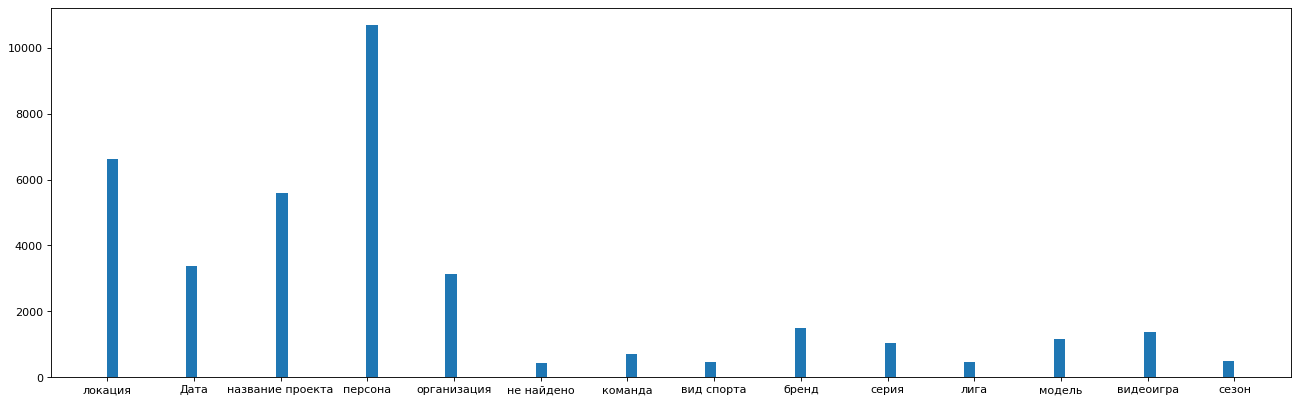

In [126]:
plt.figure(figsize=(20, 6), dpi=80)
plt.hist(variable_NER,bins=100)

#<h1>–ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ –º–µ—Ç–æ–∫ –¥–∞—Ç–∞—Å–µ—Ç–∞ –∫ —Ñ–æ—Ä–º–∞—Ç—É BIO</h1>

In [127]:
# –¢–µ–ø–µ—Ä—å –∏–∑ –Ω–∞—à–∏—Ö –¥–∞–Ω–Ω—ã—Ö –Ω–∞–º –Ω—É–∂–Ω–æ –∏–∑–≤–ª–µ—á—å –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Å–ª–æ–≤–∞ (—Ç–æ–∫–µ–Ω–∞) –µ–≥–æ —Ç–µ–≥ (label) –∏–∑ —Ä–∞–∑–º–µ—Ç–∫–∏, —á—Ç–æ–±—ã –ø–æ—Ç–æ–º –ø—Ä–µ–¥–∞—Ç—å –≤ –º–æ–¥–µ–ª—å –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ç–æ–∫–µ–Ω–æ–≤


def extract_labels(sfift_item,true_item):

    # –≤–æ—Å–ø–æ–ª—å–∑—É–µ–º—Å—è —É–¥–æ–±–Ω—ã–º —Ç–æ–∫–µ–Ω–∞–π–∑–µ—Ä–æ–º –∏–∑ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏ razdel,
    # –æ–Ω–∞ –ø–æ–º–∏–º–æ —Ä–∞–∑–±–∏–µ–Ω–∏—è –Ω–∞ —Å–ª–æ–≤–∞, —Å–æ—Ö—Ä–∞–Ω—è–µ—Ç –≤–∞–∂–Ω—ã–µ –¥–ª—è –Ω–∞—Å —á–∏—Å–ª–∞ - –Ω–∞—á–∞–ª–æ –∏ –∫–æ–Ω–µ—Ü —Å–ª–æ–≤–∞ –≤ —Ç–æ–∫–µ–Ω–∞—Ö

    raw_toks = list(tokenize(true_item))
    words = [tok.text for tok in raw_toks]
    # –ø—Ä–∏—Å–≤–æ–∏–º –¥–ª—è –Ω–∞—á–∞–ª–∞ –∫–∞–∂–¥–æ–º—É —Å–ª–æ–≤—É —Ç–µ–≥ '–û' - —Ç–µ–≥, –æ–∑–Ω–∞—á–∞—é—â–∏–π –æ—Ç—Å—É—Ç—Å—Ç–≤–∏–µ NER-–∞
    word_labels = ['O'] * len(raw_toks)
    char2word = [None] * len(true_item)
    # —Ç–∞–∫ –∫–∞–∫ NER –º–æ–∂–µ–º —Å–æ—Å—Ç–∞—è—Ç—å –∏–∑ –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö —Å–ª–æ–≤, —Ç–æ –Ω–∞–º –Ω—É–∂–Ω–æ —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å —ç—Ç—É –∏–Ω—Ñ–æ—Ä—Ü–∏—é
    for i, word in enumerate(raw_toks):
        char2word[word.start:word.stop] = [i] * len(word.text)

    labels = sfift_item['entities']
    if isinstance(labels, dict):
        labels = [labels]
    if labels is not None:
        for e in labels:
            if e['label'] != '–Ω–µ –Ω–∞–π–¥–µ–Ω–æ':
                e_words = sorted({idx for idx in char2word[int(e['offset']):int(e['offset'])+int(e['length'])] if idx is not None})
                if e_words:
                    word_labels[e_words[0]] = 'B-' + e['label']
                    for idx in e_words[1:]:
                        word_labels[idx] = 'I-' + e['label']
                else:
                    continue
            else:
                continue
        return {'tokens': words, 'tags': word_labels}
    else: return {'tokens': words, 'tags': word_labels}

In [128]:
ner_data = [extract_labels(iitem1[1],iitem2) for iitem1, iitem2 in zip(df.iterrows(),df['video_info'].tolist())]

In [129]:
import pandas as pd
pd.options.display.max_colwidth = 300
dataframe_BIO=pd.DataFrame(ner_data)


In [130]:
dataframe_BIO.sample(3)

tokens  \
5392  [<, –ù–ê–ó–í–ê–ù–ò–ï, :, >, –†–æ–¥–∏—Ç–µ–ª–∏, –≤, –∑–∞–∫–æ–Ω–µ, =, –§–∏–ª—å–º, 2023, (, Netflix, ), =, –†—É—Å—Å–∫–∏–π, —Ç—Ä–µ–π–ª–µ—Ä, –≤, —Ä–µ–π—Ç–∏–Ω–≥–µ, <, –û–ü–ò–°–ê–ù–ò–ï, :, >, #, kino, –ü—Ä–æ—Å—Ç–æ–≤–∞—Ç—ã–π, –±–∞–Ω–∫–æ–≤—Å–∫–∏–π, –º–µ–Ω–µ–¥–∂–µ—Ä, —Å–æ–±–∏—Ä–∞–µ—Ç—Å—è, –∂–µ–Ω–∏—Ç—å—Å—è, –Ω–∞, –ª—é–±–≤–∏, –≤—Å–µ–π, —Å–≤–æ–µ–π, –∂–∏–∑–Ω–∏, ,, –Ω–æ, –≤—Å—ë, –ø–æ—Ä—Ç–∏—Ç, —Ç–æ—Ç, –º–æ–º–µ–Ω—Ç, ,, —á—Ç–æ, –µ–≥–æ, –±–∞–Ω–∫, –≥—Ä–∞–±—è—Ç, –Ω–µ—É–ª–æ–≤–∏–º—ã–µ, –±–∞...   
2301  [<, –ù–ê–ó–í–ê–ù–ò–ï, :, >, –ó–∞–º–µ–Ω–∞, –º–∞—Å–ª–∞, –≤, –¥–≤–∏–≥–∞—Ç–µ–ª–µ, Mitsubishi, Outlander, 3, –ø–µ—Ä–µ—à–ª–∏, –Ω–∞, –æ—Ç–µ—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–≥–æ, –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—è, <, –û–ü–ò–°–ê–ù–ò–ï, :, >, –°–∏–Ω—Ç–µ—Ç–∏—á–µ—Å–∫–æ–µ, –º–æ—Ç–æ—Ä–Ω–æ–µ, –º–∞—Å–ª–æ, –õ–£–ö–û–ô–õ, Genesis, Armortech, JP, 5, W, 30, –Ω–∞, –Ø–Ω–¥–µ–∫—Å, –ú–∞—Ä–∫–µ—Ç, <, LINK, >, <, LINK, >, –î–∑–µ–Ω, <, LINK, >, VK, <, LINK, >, OK, <,...   
2643  [<, –ù–ê–ó–í–ê–ù–ò–ï, :, >, ‚ö°, –ú–µ–Ω—è—é—â–∏–µ, —Ä–µ–∞–ª—å–Ω–æ—Å—Ç—å, ‚ö°, –§–∏–ª—å–º, 2011, –≥–æ–¥–∞, ‚ö°, –†—É—Å—Å–∫–∏–π, –¢—Ä–µ–π–ª–µ—Ä, <, –û–ü–ò–°–ê–ù–ò–ï, :, >, üì¢, –†—É—Å—Å–∫–∏–π, –¢—Ä–µ–π–ª–µ—Ä, –∫, —Ñ–∏–ª—å–º—É, ‚ñ∫, –ú–µ–Ω—è—é—â–∏–µ, —Ä–µ–∞–ª—å–Ω–æ—Å—Ç—å, üé•, –§–∏–ª—å–º, 2011, –≥–æ–¥–∞, üö•, –ñ–∞–Ω—Ä, ‚ñ∫, —Ñ–∞–Ω—Ç–∞—Å—Ç–∏–∫–∞, ,, —Ç—Ä–∏–ª–ª–µ—Ä, ,, –º–µ–ª–æ–¥—Ä–∞–º–∞, ‚ö°, –í–æ–∑—Ä–∞—Å—Ç–Ω—ã–µ, –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è, ‚ñ∫, 12, +, üé≠, –û, —á–µ–º, ‚ñ∫, –°–ª—É—á–∞–π–Ω–æ...   

                                                                                                                                                                                                                                                                                                             tags  
5392                                                                          [O, O, O, O, O, O, O, O, O, B-–î–∞—Ç–∞, O, B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]  
2301  [O, O, O, O, O, O, O, O, B-–±—Ä–µ–Ω–¥, B-–º–æ–¥–µ–ª—å, I-–º–æ–¥–µ–ª—å, O, O, O, O, O, O, O, O, O, O, O, B-–±—Ä–µ–Ω–¥, B-–º–æ–¥–µ–ª—å, I-–º–æ–¥–µ–ª—å, I-–º–æ–¥–µ–ª—å, I-–º–æ–¥–µ–ª—å, I-–º–æ–¥–µ–ª—å, I-–º–æ–¥–µ–ª—å, O, B-–±—Ä–µ–Ω–¥, I-–±—Ä–µ–Ω–¥, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...  
2643  [O, O, O, O, O, B-–Ω–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞, I-–Ω–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞, O, O, B-–î–∞—Ç–∞, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-–Ω–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞, I-–Ω–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞, O, O, B-–î–∞—Ç–∞, I-–î–∞—Ç–∞, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-–ø–µ—Ä—Å–æ–Ω–∞, I-–ø–µ—Ä—Å–æ–Ω–∞, I-–ø–µ—Ä—Å–æ–Ω–∞, I-–ø–µ—Ä—Å–æ–Ω–∞, B-–ø–µ—Ä—Å–æ–Ω–∞, I-–ø–µ—Ä—Å–æ–Ω–∞,...

#Pip–µline: dataset to prediction

–±–µ—Ä–µ—Ç—Å—è –¥–∞—Ç–∞—Å–µ—Ç, —Å–æ—Å—Ç–æ—è—â–∏–π —Ç–æ–ª—å–∫–æ –∏–∑ video_info

In [131]:
test_df=dataframe['video_info'][:20]

–ü—Ä–æ–∏–∑–≤–æ–¥–∏—Ç—Å—è –ø–æ–∏—Å–∫ NER

In [132]:
from tqdm import tqdm

def analise_dataset(test_df):

  video_infos=[]
  analise_dicts=[]
  for video_info in tqdm(test_df):
    analise_dict=full_analise_dForm(video_info)
    #—É–¥–∞–ª–∏ –ø–æ—Ç–æ–º clear_text, —Å–µ–π—á–∞—Å —ç—Ç–æ –¥–ª—è –≤–∏–∑—É–∞–ª–∞
    video_infos.append(clear_text(video_info))
    analise_dicts.append(analise_dict)

  submission = pd.DataFrame(list(zip(video_infos,analise_dicts)),columns=[['video_info', 'entities']])
  return submission

In [133]:
submission=analise_dataset(test_df)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 11.21it/s]


In [134]:
submission.sample(3)

video_info  \
2   ___________ –í–´–ó–û–í –î–ï–ú–û–ù–ê = –í—ã–∑–≤–∞–ª –°–µ—Ä–æ–≥–æ –ß–µ–ª–æ–≤–µ–∫–∞ [–ö–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π —Ñ–∏–ª—å–º] #—Å–µ—Ä—ã–π—á–µ–ª–æ–≤–µ–∫, #–∫–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π—Ñ–∏–ª—å–º ___________–í–´–ó–û–í –î–ï–ú–û–ù–ê –í—ã–∑–≤–∞–ª –°–µ—Ä–æ–≥–æ –ß–µ–ª–æ–≤–µ–∫–∞ [–ö–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π —Ñ–∏–ª—å–º] #—Å–µ—Ä—ã–π—á–µ–ª–æ–≤–µ–∫, #–∫–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π—Ñ–∏–ª—å–º –°–ø–∞—Å–∏–±–æ –∑–∞ –ø—Ä–æ—Å–º–æ—Ç—Ä. –í –∫–∞—á–µ—Å—Ç–≤–µ –æ–ø–ª–∞—Ç—ã —Å –≤–∞—Å –ª–∞–π–∫ –∏ –ø–æ–¥–ø–∏—Å–∫–∞) –°—Å—ã–ª–∫–∏ –Ω–∞ –º...   
13  ___________ –ß—Ç–æ –¥–µ–ª–∞—Ç—å –∂–µ–Ω—â–∏–Ω–µ, –µ—Å–ª–∏ —É –Ω–µ—ë –¥–≤–∞ –ª—é–±–æ–≤–Ω–∏–∫–∞, –∞ –≤—ã–±—Ä–∞—Ç—å –Ω—É–∂–Ω–æ –æ–¥–Ω–æ–≥–æ (2022) 1,2,3,4,5,6,7,8 —Å–µ—Ä–∏—è ___________–ê–Ω–Ω–∞ ‚Äî —É—Å–ø–µ—à–Ω—ã–π –∞–¥–≤–æ–∫–∞—Ç, –∫–æ—Ç–æ—Ä–∞—è –Ω–µ —Å—Ç–µ—Å–Ω—è—è—Å—å –≥–æ–≤–æ—Ä–∏—Ç —Å–≤–æ–µ–π –¥–∞–≤–Ω–µ–π –ø–æ–¥—Ä—É–≥–µ –õ–∞—Ä–∏—Å–µ, —á—Ç–æ —Ö–æ—á–µ—Ç –≤—ã–±—Ä–∞—Ç—å ¬´–º—É–∂–∞ –Ω–∞ —Ç—Ä–∏ –º–µ—Å—è—Ü–∞¬ª, —Ç–∞–∫ –∫–∞–∫ —É –Ω–µ–µ —Å–ª–æ–∂–Ω—ã–π –ø—Ä–æ–µ–∫—Ç –∏ –Ω—É–∂–µ–Ω –≥—Ä–æ–º–æ–æ—Ç–≤–æ–¥ –∏ –ø–æ...   
3   ___________ –î–æ–≤–æ–µ–Ω–Ω–∞—è –Ω–µ–º–µ—Ü–∫–∞—è –∫–∏—Ä—Ö–∞ –≤ –ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏. –ü–æ—Å–µ—Ç–∏–ª–∏ –≤–º–µ—Å—Ç–µ —Å #–ó–∞–±—Ä–æ—à–∫–∏39! ___________–•–æ—á–µ—à—å –Ω–æ–≤—ã—Ö —ç–º–æ—Ü–∏–π, –ø–æ–±—ã–≤–∞—Ç—å –≤ –Ω–µ–æ–±—ã—á–Ω—ã—Ö –º–µ—Å—Ç–∞—Ö, —Ç–æ–≥–¥–∞ –ø—Ä–∏—Å–æ–µ–¥–∏–Ω—è–π—Å—è –∫ –Ω–∞–º <AT>! –ê–≤—Ç–æ–º–æ–±–∏–ª—å–Ω—ã–µ –ø—É—Ç–µ—à–µ—Å—Ç–≤–∏—è –ø–æ –∑–∞–±—Ä–æ—à–µ–Ω–Ω—ã–º —Å—Ç–∞—Ä–∏–Ω–Ω—ã–º —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è–º. –°–∞–º—ã–µ –Ω–µ–æ–±—ã—á–Ω—ã–µ –º–µ—Å—Ç–∞ –ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç...   

                                                                                                                                                                                                                                                                                                       entities  
2                                                                                                                                                                                                                                   [{'label': '–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è', 'offset': 380, 'length': 6, 'segment': 'Rutube'}]  
13  [{'label': '–ø–µ—Ä—Å–æ–Ω–∞', 'offset': 121, 'length': 4, 'segment': '–ê–Ω–Ω–∞'}, {'label': '–ø–µ—Ä—Å–æ–Ω–∞', 'offset': 196, 'length': 6, 'segment': '–õ–∞—Ä–∏—Å–µ'}, {'label': '–ø–µ—Ä—Å–æ–Ω–∞', 'offset': 481, 'length': 4, 'segment': '–ê–Ω–Ω–∞'}, {'label': '–ª–æ–∫–∞—Ü–∏—è', 'offset': 604, 'length': 6, 'segment': '–ê–Ω–≥–ª–∏–∏'}, {'label': '–ø–µ—Ä—Å...  
3   [{'label': '–ø–µ—Ä—Å–æ–Ω–∞', 'offset': 12, 'length': 9, 'segment': '–î–æ–≤–æ–µ–Ω–Ω–∞—è'}, {'label': '–ª–æ–∫–∞—Ü–∏—è', 'offset': 39, 'length': 23, 'segment': '–ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏'}, {'label': '–ª–æ–∫–∞—Ü–∏—è', 'offset': 274, 'length': 23, 'segment': '–ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏'}, {'label': '–ª–æ–∫–∞—Ü–∏—è', 'offset': 401, 'length':...

–ú–µ—Ç–∫–∏ –ø—Ä–∏–≤–æ–¥—è—Ç—Å—è –∫ —Ñ–æ—Ä–º–∞—Ç—É BIO

In [135]:
prediction = [extract_labels(iitem1[1],iitem2) for iitem1, iitem2 in zip(submission.iterrows(),test_df.tolist())]
prediction_BIO=pd.DataFrame(prediction)

In [136]:
prediction_BIO.sample(3)

tokens  \
10  [<, –ù–ê–ó–í–ê–ù–ò–ï, :, >, –ö–æ—Å–º–∏—á–µ—Å–∫–∏–µ, –∏—Å—Ç–æ—Ä–∏–∏, ., –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞, –∫–æ—Å–º–æ–Ω–∞–≤—Ç–æ–≤, –¥–ª—è, —Ä–∞–±–æ—Ç—ã, –≤, —ç–∫—Å—Ç—Ä–µ–º–∞–ª—å–Ω—ã—Ö, —É—Å–ª–æ–≤–∏—è—Ö, ., –í—ã–ø—É—Å–∫, 09.03.2023, <, –û–ü–ò–°–ê–ù–ò–ï, :, >, –í–µ–¥—É—â–∏–π, –ø–æ–¥–∫–∞—Å—Ç–∞, ,, –∫–æ—Å–º–æ–Ω–∞–≤—Ç, –ê–Ω—Ç–æ–Ω, –®–∫–∞–ø–ª–µ—Ä–æ–≤, ,, –±–µ—Å–µ–¥—É–µ—Ç, —Å, –∏–Ω—Å—Ç—Ä—É–∫—Ç–æ—Ä–æ–º, –∏—Å–ø—ã—Ç–∞—Ç–µ–ª–µ–º, –¶–ü–ö, –ê–Ω–∞—Ç–æ–ª–∏–µ–º, –ó–∞–±—Ä—É—Å–∫–æ–≤—ã–º, ., –ß–µ—Ä–µ–∑, –∫–∞–∫–∏–µ, —ç–∫—Å...   
9   [<, –ù–ê–ó–í–ê–ù–ò–ï, :, >, –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞, –∫, –æ—Ç–æ–ø–∏—Ç–µ–ª—å–Ω–æ–º—É, —Å–µ–∑–æ–Ω—É, :, –≤, –•–∞–±–∞—Ä–æ–≤—Å–∫–µ, –ø—Ä–æ–≤–µ—Ä–∏–ª–∏, –ø—Ä–æ–±–ª–µ–º–Ω—ã–µ, –º–Ω–æ–≥–æ–∫–≤–∞—Ä—Ç–∏—Ä–Ω—ã–µ, –¥–æ–º–∞, <, –û–ü–ò–°–ê–ù–ò–ï, :, >, –û—Ç–æ–ø–ª–µ–Ω–∏–µ, –≤, –¥–æ–º–∞—Ö, —Ö–∞–±–∞—Ä–æ–≤—á–∞–Ω, –≤–∫–ª—é—á–∞—Ç, 8, –æ–∫—Ç—è–±—Ä—è, ., –ü–∞—Å–ø–æ—Ä—Ç–∞, –≥–æ—Ç–æ–≤–Ω–æ—Å—Ç–∏, —É–ø—Ä–∞–≤–ª—è—é—â–∏–µ, –∫–æ–º–ø–∞–Ω–∏–∏, –ø–æ–ª—É—á–∏–ª–∏, –µ—â—ë, –¥–æ, 15, —Å–µ–Ω—Ç—è–±—Ä—è, ., –ù–æ, ,, –∫–∞–∫, –ø–æ–∫–∞–∑...   
4   [<, –ù–ê–ó–í–ê–ù–ò–ï, :, >, ", –°–ø–∞—Ä—Ç–∞–∫—É, ", –ø–æ–º–æ–≥–ª–∏, —Å—É–¥—å–∏, ?, –õ–æ–∫–æ–º–æ—Ç–∏–≤, –∑–∞—Å—É–¥–∏–ª–∏, ?, –°—Ç–æ–∏–ª–æ, –ª–∏, –æ—Ç–º–µ–Ω—è—Ç—å, –≥–æ–ª, ?, <, –û–ü–ò–°–ê–ù–ò–ï, :, >, –°–ø–∞—Ä—Ç–∞–∫, #, –õ–æ–∫–æ–º–æ—Ç–∏–≤, #, –æ–±–∑–æ—Ä, #, –æ–±–∑–æ—Ä–º–∞—Ç—á–∞, #, –≤—Å–µ–≥–æ–ª—ã, #, –õ–æ–∫–æ, #, –õ–æ–∫–æ–º–æ—Ç–∏–≤–ú–æ—Å–∫–≤–∞, #, –≥–æ–ª–ü—Ä—É—Ü–µ–≤–∞, #, –õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫–æ–±–∑–æ—Ä, #, –õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫–ø–æ–ª–Ω—ã–π–º–∞—Ç—á, #, –ö—É–±–æ...   

                                                                                                                                                                                                                                                                                                           tags  
10  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-–î–∞—Ç–∞, O, O, O, O, O, O, O, O, B-–ø–µ—Ä—Å–æ–Ω–∞, I-–ø–µ—Ä—Å–æ–Ω–∞, O, O, O, O, O, B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è, B-–ø–µ—Ä—Å–æ–Ω–∞, I-–ø–µ—Ä—Å–æ–Ω–∞, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
9   [O, O, O, O, O, O, O, O, O, O, B-–ª–æ–∫–∞—Ü–∏—è, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-–ø–µ—Ä—Å–æ–Ω–∞, I-–ø–µ—Ä—Å–æ–Ω–∞, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-–ª–æ–∫–∞—Ü–∏—è, O, O,...  
4                                                                         [O, O, O, O, O, B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è, O, B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-–ª–æ–∫–∞—Ü–∏—è, O, O, O, O, O, O, O, B-–ø–µ—Ä—Å–æ–Ω–∞, O, B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è]

In [137]:
def get_predict(test_df):
  submission=analise_dataset(test_df)
  prediction = [extract_labels(iitem1[1],iitem2) for iitem1, iitem2 in zip(submission.iterrows(),test_df.tolist())]

  prediction_BIO=pd.DataFrame(prediction)
  #predictions=[]
  #for x in prediction:
  #  predictions.append(x)

  #prediction_BIO = pd.DataFrame(zip(test_df.tolist(),predictions))
  #prediction = pd.DataFrame([extract_labels(item) for i, item in submission.iterrows()])
  prediction_BIO=pd.DataFrame(list(zip(test_df.tolist(),prediction_BIO['tags'].tolist())),columns=['video_info','entities_prediction'])
  #prediction_BIO=pd.DataFrame(zip(test_df,prediction),columns=['video_info','entities_prediction'])
  return prediction_BIO

In [138]:
prediction=get_predict(test_df)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:01<00:00, 11.76it/s]


In [139]:
prediction

video_info  \
0   <–ù–ê–ó–í–ê–ù–ò–ï:> –ê–≥–µ–Ω—Ç 117: –ò–∑ –ê—Ñ—Ä–∏–∫–∏ —Å –ª—é–±–æ–≤—å—é ‚Äî –†—É—Å—Å–∫–∏–π —Ç–∏–∑–µ—Ä=—Ç—Ä–µ–π–ª–µ—Ä (2021) <–û–ü–ò–°–ê–ù–ò–ï:>–õ—É—á—à–∏–π Telegram –∫–∞–Ω–∞–ª –æ –∫–∏–Ω–æ <LINK> –°–æ—Ç—Ä—É–¥–Ω–∏—á–µ—Å—Ç–≤–æ <LINK> –î–∞—Ç–∞ –≤—ã—Ö–æ–¥–∞ 26 –∞–≤–≥—É—Å—Ç–∞ 2021 –û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ –Ω–∞–∑–≤–∞–Ω–∏–µ: OSS 117: Alerte rouge en Afrique noire –°—Ç—Ä–∞–Ω–∞: –§—Ä–∞–Ω—Ü–∏—è –†–µ–∂–∏—Å—Å–µ—Ä: –ù–∏–∫–æ–ª—è –ë–µ–¥–æ—Å –ñ–∞–Ω—Ä: –±–æ–µ–≤–∏–∫, –∫–æ–º–µ–¥–∏—è –í ...   
1   <–ù–ê–ó–í–ê–ù–ò–ï:> –ö–æ–ª–µ–Ω–≤–∞–ª –ò–Ω—Ñ–∏–Ω–∏—Ç–∏ –ö—É –∏–∫—Å 56= 5.6 VK56 VK56DE VK56=DE –ö–æ–ª–µ–Ω–Ω—ã–π –í–∞–ª Infiniti QX56= 5.6 —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–π <–û–ü–ò–°–ê–ù–ò–ï:><LINK> kolenval infiniti iks.html –ö–æ–ª–µ–Ω–≤–∞–ª –ò–Ω—Ñ–∏–Ω–∏—Ç–∏ –ö—É –∏–∫—Å 56‚Äã –ö–æ–ª–µ–Ω–Ω—ã–π –í–∞–ª Infiniti QX56‚Äã –ú–æ–¥–µ–ª—å –î–≤–∏–≥–∞—Ç–µ–ª—è: VK56, VK56DE, VK56 DE –†–∞–±–æ—á–∏–π –æ–±—ä–µ–º –¥–≤–∏–≥–∞—Ç–µ–ª—è: 5.6 –ú–æ—â–Ω–æ—Å—Ç—å –≤ –ª.—Å. ...   
2   <–ù–ê–ó–í–ê–ù–ò–ï:> –í–´–ó–û–í –î–ï–ú–û–ù–ê = –í—ã–∑–≤–∞–ª –°–µ—Ä–æ–≥–æ –ß–µ–ª–æ–≤–µ–∫–∞ [–ö–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π —Ñ–∏–ª—å–º] #—Å–µ—Ä—ã–π—á–µ–ª–æ–≤–µ–∫, #–∫–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π—Ñ–∏–ª—å–º <–û–ü–ò–°–ê–ù–ò–ï:>–í–´–ó–û–í –î–ï–ú–û–ù–ê –í—ã–∑–≤–∞–ª –°–µ—Ä–æ–≥–æ –ß–µ–ª–æ–≤–µ–∫–∞ [–ö–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π —Ñ–∏–ª—å–º] #—Å–µ—Ä—ã–π—á–µ–ª–æ–≤–µ–∫, #–∫–æ—Ä–æ—Ç–∫–æ–º–µ—Ç—Ä–∞–∂–Ω—ã–π—Ñ–∏–ª—å–º –°–ø–∞—Å–∏–±–æ –∑–∞ –ø—Ä–æ—Å–º–æ—Ç—Ä. –í –∫–∞—á–µ—Å—Ç–≤–µ –æ–ø–ª–∞—Ç—ã —Å –≤–∞—Å –ª–∞–π–∫ –∏ –ø–æ–¥–ø–∏—Å–∫–∞) –°—Å—ã–ª–∫–∏ –Ω–∞ –º...   
3   <–ù–ê–ó–í–ê–ù–ò–ï:> –î–æ–≤–æ–µ–Ω–Ω–∞—è –Ω–µ–º–µ—Ü–∫–∞—è –∫–∏—Ä—Ö–∞ –≤ –ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç–∏. –ü–æ—Å–µ—Ç–∏–ª–∏ –≤–º–µ—Å—Ç–µ —Å #–ó–∞–±—Ä–æ—à–∫–∏39! <–û–ü–ò–°–ê–ù–ò–ï:>–•–æ—á–µ—à—å –Ω–æ–≤—ã—Ö —ç–º–æ—Ü–∏–π, –ø–æ–±—ã–≤–∞—Ç—å –≤ –Ω–µ–æ–±—ã—á–Ω—ã—Ö –º–µ—Å—Ç–∞—Ö, —Ç–æ–≥–¥–∞ –ø—Ä–∏—Å–æ–µ–¥–∏–Ω—è–π—Å—è –∫ –Ω–∞–º <AT>! –ê–≤—Ç–æ–º–æ–±–∏–ª—å–Ω—ã–µ –ø—É—Ç–µ—à–µ—Å—Ç–≤–∏—è –ø–æ –∑–∞–±—Ä–æ—à–µ–Ω–Ω—ã–º —Å—Ç–∞—Ä–∏–Ω–Ω—ã–º —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è–º. –°–∞–º—ã–µ –Ω–µ–æ–±—ã—á–Ω—ã–µ –º–µ—Å—Ç–∞ –ö–∞–ª–∏–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–æ–π –æ–±–ª–∞—Å—Ç...   
4   <–ù–ê–ó–í–ê–ù–ò–ï:> "–°–ø–∞—Ä—Ç–∞–∫—É" –ø–æ–º–æ–≥–ª–∏ —Å—É–¥—å–∏? –õ–æ–∫–æ–º–æ—Ç–∏–≤ –∑–∞—Å—É–¥–∏–ª–∏? –°—Ç–æ–∏–ª–æ –ª–∏ –æ—Ç–º–µ–Ω—è—Ç—å –≥–æ–ª? <–û–ü–ò–°–ê–ù–ò–ï:>–°–ø–∞—Ä—Ç–∞–∫ #–õ–æ–∫–æ–º–æ—Ç–∏–≤ #–æ–±–∑–æ—Ä #–æ–±–∑–æ—Ä–º–∞—Ç—á–∞ #–≤—Å–µ–≥–æ–ª—ã #–õ–æ–∫–æ #–õ–æ–∫–æ–º–æ—Ç–∏–≤–ú–æ—Å–∫–≤–∞ #–≥–æ–ª–ü—Ä—É—Ü–µ–≤–∞ #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫–æ–±–∑–æ—Ä #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫–ø–æ–ª–Ω—ã–π–º–∞—Ç—á #–ö—É–±–æ–∫ #–ö—É–±–æ–∫–†–æ—Å—Å–∏–∏ #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø–∞—Ä—Ç–∞–∫—Å—É–¥—å—è #–æ—Ç–º–µ–Ω–µ–Ω–Ω—ã–π–≥–æ–ª #–õ–æ–∫–æ–º–æ—Ç–∏–≤–°–ø...   
5   <–ù–ê–ó–í–ê–ù–ò–ï:> –ê–Ω–µ–∫–¥–æ—Ç = –í –≤–∞—à–µ–º –±–æ—Ä—â–µ –º–æ—è –∫—É—Ä–æ—á–∫–∞))) –°–º–µ—à–Ω—ã–µ –∞–Ω–µ–∫–¥–æ—Ç—ã –æ—Ç –¢–∞–ª–∏–≤–µ—Ä–≥–∞ ))) –Æ–º–æ—Ä –°–º–µ—Ö –ü–æ–∑–∏—Ç–∏–≤! <–û–ü–ò–°–ê–ù–ò–ï:>–ê–Ω–µ–∫–¥–æ—Ç –∫–∞–∫ –µ–≤—Ä–µ–π –ø–æ–¥–æ—à–µ–ª –∫ —Å–≤–æ–µ–π —Å–æ—Å–µ–¥–∫–µ –∏ –ø—Ä–µ–¥–ª–æ–∂–∏–ª –µ–π –Ω–∞ –µ—ë –º–∞—Å–ª–µ –ø–æ–∂–∞—Ä–∏—Ç—å —Å–µ–±–µ —è–∏—á–Ω–∏—Ü—É...–°–º–µ—à–Ω—ã–µ –∞–Ω–µ–∫–¥–æ—Ç—ã –æ—Ç –¢–∞–ª–∏–≤–µ—Ä–≥–∞)))–í—Å–µ–º –ø—Ä–∏—è—Ç–Ω–æ–≥–æ –ø—Ä–æ—Å–º–æ—Ç—Ä–∞ #–ê–Ω–µ–∫–¥–æ—Ç—ã #—Å–º–µ—à–Ω—ã–µ–ê–Ω–µ–∫–¥—Ç—ã #—Å–º–µ—à...   
6   <–ù–ê–ó–í–ê–ù–ò–ï:> –ü–∞–≤—à–∏–º –≤ –±–æ—è—Ö –∑–∞ –æ–±–æ—Ä–æ–Ω—É —Å–≤–æ–µ–π —Ä–æ–¥–∏–Ω—ã = –ø–æ—Å–≤—è—â–∞–µ—Ç—Å—è: 35=—è –±—Ä–æ–Ω–µ–±–∞—à–µ–Ω–Ω–∞—è –±–∞—Ç–∞—Ä–µ—è <–û–ü–ò–°–ê–ù–ò–ï:>–ú–æ–π –ª–∏—á–Ω—ã–π –±–ª–æ–≥ –æ –ü—É—Ç–µ—à–µ—Å—Ç–≤–∏—è—Ö: <LINK> #–±–ª–æ–≥ #—Ç—Ä–µ–≤–ª #–ø—É—Ç–µ—à–µ—Å—Ç–≤–∏—è #–∑–∞—Ä–∞–±–æ—Ç–æ–∫ ‚ñ∫–ü–æ–¥–¥–µ—Ä–∂–∞—Ç—å –∫–∞–Ω–∞–ª (–¥–æ–Ω–∞—Ç): <LINK> ‚ñ∫–ú–æ–π –∫–∞–Ω–∞–ª –≤ –Ø–Ω–¥–µ–∫—Å –î–∑–µ–Ω: zen.yandex.ru/alexandr_rodiaev ‚ñ∫–ò–Ω—Å—Ç–∞–≥—Ä–∞–º<LINK>... ‚ñ∫–í–ö–æ–Ω—Ç...   
7   <–ù–ê–ó–í–ê–ù–ò–ï:> 6 –º–∞—Ä—Ç–∞ 2022 –≥. –ö–∞—Ä–∞—Ç—ç —à–æ—Ç–æ–∫–∞–Ω. –ö—Ä–∞–µ–≤—ã–µ —Å–æ—Ä–µ–≤–Ω–æ–≤–∞–Ω–∏—è –ø–æ –≤—Å–µ—Å—Ç–∏–ª–µ–≤–æ–º—É –∫–∞—Ä–∞—Ç—ç. –ö—É–º–∏—Ç—ç —Å—ë–±—É=—Å–∞–Ω–±–æ–Ω = 09 <–û–ü–ò–°–ê–ù–ò–ï:>–ö—Ä–∞–µ–≤—ã–µ —Å–æ—Ä–µ–≤–Ω–æ–≤–∞–Ω–∏—è –ø–æ –≤—Å–µ—Å—Ç–∏–ª–µ–≤–æ–º—É –∫–∞—Ä–∞—Ç—ç. –ö–∞—Ä–∞—Ç—ç —à–æ—Ç–æ–∫–∞–Ω. –°—ë–±—É —Å–∞–Ω–±–æ–Ω –¥–

#<h1>–ü–æ–¥—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫</h1>

In [140]:
import numpy as np

In [141]:
from datasets import load_dataset, load_metric
metric = load_metric("seqeval")
def calculate_matric(dataframe):

  ner_data = [extract_labels(iitem1[1],iitem2) for iitem1, iitem2 in zip(dataframe.iterrows(),dataframe['video_info'].tolist())]
  dataframe_BIO=pd.DataFrame(ner_data)
  y_true=dataframe_BIO['tags'].tolist()

  y_predict=get_predict(dataframe['video_info'])['entities_prediction'].tolist()


  arr=metric.compute(predictions=y_predict, references=y_true)

  return arr



In [142]:
mertics=calculate_matric(df)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6042/6042 [04:12<00:00, 23.94it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
mertics

{'–î–∞—Ç–∞': {'precision': 0.5825545171339563,
  'recall': 0.16912873078082605,
  'f1': 0.26214953271028035,
  'number': 3317},
 '–±—Ä–µ–Ω–¥': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1492},
 '–≤–∏–¥ —Å–ø–æ—Ä—Ç–∞': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 467},
 '–≤–∏–¥–µ–æ–∏–≥—Ä–∞': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1288},
 '–∫–æ–º–∞–Ω–¥–∞': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 713},
 '–ª–∏–≥–∞': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 450},
 '–ª–æ–∫–∞—Ü–∏—è': {'precision': 0.5000587751263665,
  'recall': 0.6439600363306085,
  'f1': 0.5629590418844704,
  'number': 6606},
 '–º–æ–¥–µ–ª—å': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1156},
 '–Ω–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞': {'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'number': 5394},
 '–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è': {'precision': 0.10604598810098087,
  'recall': 0.4210022342802426,
  'f1': 0.16941750690385976,
  'number': 3133},
 '–ø–µ—Ä—Å–æ–Ω

#<h1>playground</h1>

In [97]:
#–º–æ–¥–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–π get_predict –¥–ª—è —É–¥–æ–±–Ω–æ–≤–æ –≤–≤–æ–¥–∞ —Å–æ —Å—Ç–æ—Ä–æ–Ω—ã –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è
def get_predict_modify(text):
  data=pd.DataFrame([[text]])
  y_pred=get_predict(data[0])
  return y_pred

In [102]:
text="""–ö–∏–Ω–æ–∑–∞–ª –î–ö –ø—Ä–∏–≥–ª–∞—à–∞–µ—Ç –Ω–∞ –º—É–ª—å—Ç—Ñ–∏–ª—å–º "–ü–æ—Ç–µ—Ä—è—à–∫–∏ –∏ –¢–∞–π–Ω–∞ –≤–æ–ª—à–µ–±–Ω–æ–π –ø–∏—Ä–∞–º–∏–¥—ã", 6+, 80 –º–∏–Ω. #–∫–∏–Ω–æ–∑–∞–ª–î–ö—è–º <–û–ü–ò–°–ê–ù–ò–ï:>–ö–∏–Ω–æ–∑–∞–ª –î–ö –ì–∞–≤—Ä–∏–ª–æ–≤ –Ø–º—Å–∫–æ–≥–æ –ú–† –ø—Ä–∏–≥–ª–∞—à–∞–µ—Ç —Å 31 –º–∞—Ä—Ç–∞ –Ω–∞ –º—É–ª—å—Ç—Ñ–∏–ª—å–º "–ü–æ—Ç–µ—Ä—è—à–∫–∏ –∏ –¢–∞–π–Ω–∞ –≤–æ–ª—à–µ–±–Ω–æ–π –ø–∏—Ä–∞–º–∏–¥—ã", 6+, 80 –º–∏–Ω. –°—Ç–æ–∏–º–æ—Å—Ç—å –±–∏–ª–µ—Ç–æ–≤ 100 220 —Ä—É–±."""

In [103]:
get_predict_modify(text)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 41.48it/s]


video_info  \
0  –ö–∏–Ω–æ–∑–∞–ª –î–ö –ø—Ä–∏–≥–ª–∞—à–∞–µ—Ç –Ω–∞ –º—É–ª—å—Ç—Ñ–∏–ª—å–º "–ü–æ—Ç–µ—Ä—è—à–∫–∏ –∏ –¢–∞–π–Ω–∞ –≤–æ–ª—à–µ–±–Ω–æ–π –ø–∏—Ä–∞–º–∏–¥—ã", 6+, 80 –º–∏–Ω. #–∫–∏–Ω–æ–∑–∞–ª–î–ö—è–º <–û–ü–ò–°–ê–ù–ò–ï:>–ö–∏–Ω–æ–∑–∞–ª –î–ö –ì–∞–≤—Ä–∏–ª–æ–≤ –Ø–º—Å–∫–æ–≥–æ –ú–† –ø—Ä–∏–≥–ª–∞—à–∞–µ—Ç —Å 31 –º–∞—Ä—Ç–∞ –Ω–∞ –º—É–ª—å—Ç—Ñ–∏–ª—å–º "–ü–æ—Ç–µ—Ä—è—à–∫–∏ –∏ –¢–∞–π–Ω–∞ –≤–æ–ª—à–µ–±–Ω–æ–π –ø–∏—Ä–∞–º–∏–¥—ã", 6+, 80 –º–∏–Ω. –°—Ç–æ–∏–º–æ—Å—Ç—å –±–∏–ª–µ—Ç–æ–≤ 100 220 —Ä—É–±.   

                                                                                                                                                                                                            entities_prediction  
0  [B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è, I-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è, B-–ø–µ—Ä—Å–æ–Ω–∞, I-–ø–µ—Ä—Å–æ–Ω–∞, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]

#<h1>–î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ<h2>

–°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Ä–∞–∑–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π –¥–ª—è NER

In [ ]:
text="–®–æ—É ¬´–Ø—Ä—á–µ –∑–≤—ë–∑–¥¬ª —Å–æ–±–µ—Ä–µ—Ç —Å–∞–º—ã—Ö —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤—ã—Ö –≤–æ–∫–∞–ª–∏—Å—Ç–æ–≤ –∏ –ø—Ä–∏—Ä–æ–∂–¥–µ–Ω–Ω—ã—Ö –∞—Ä—Ç–∏—Å—Ç–æ–≤ –∏–∑ –Ω–∞—Ä–æ–¥–∞ –Ω–∞ –æ–¥–Ω–æ–π —Å—Ü–µ–Ω–µ. –í—Å–µ –æ–Ω–∏ –±—É–¥—É—Ç –ø–µ—Ä–µ–≤–æ–ø–ª–æ—â–∞—Ç—å—Å—è –≤ —Å–≤–æ–∏—Ö –ª—é–±–∏–º—ã—Ö –∏—Å–ø–æ–ª–Ω–∏—Ç–µ–ª–µ–π, –∞ —Ç–æ—Ç, –∫—Ç–æ —Å–¥–µ–ª–∞–µ—Ç —ç—Ç–æ —É–±–µ–¥–∏—Ç–µ–ª—å–Ω–µ–µ –æ—Å—Ç–∞–ª—å–Ω—ã—Ö, –ø–æ–ª—É—á–∏—Ç –≤–Ω—É—à–∏—Ç–µ–ª—å–Ω—ã–π –¥–µ–Ω–µ–∂–Ω—ã–π –ø—Ä–∏–∑ –∏, –∫–æ–Ω–µ—á–Ω–æ, –≤—Å–µ—Ä–æ—Å—Å–∏–π—Å–∫—É—é —Å–ª–∞–≤—É –∏ –ø—Ä–∏–∑–Ω–∞–Ω–∏–µ –∑–≤—ë–∑–¥ —ç—Å—Ç—Ä–∞–¥—ã."

In [ ]:
import spacy

nlp = spacy.load("ru_core_news_sm")
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)

In [ ]:
exctract_NER(text)

[]

–°—Ä–∞–≤–Ω–µ–Ω–∏–µ y_true –∏ y_pred

In [ ]:
def contrast_entites(df):
  y_pred=analise_dataset(df['video_info'])
  #y_pred=get_predict(df['video_info'])
  y_pred['start entities']=df['entities'].tolist()
  return y_pred

In [ ]:
y_pred=contrast_entites(df.loc[2000:3000])

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1001/1001 [00:46<00:00, 21.59it/s]


In [ ]:
y_pred.to_csv('./test.csv', index=False, encoding='utf-8',sep=';')

TO DO

In [ ]:
"""
 {'–î–∞—Ç–∞', +
 '–±—Ä–µ–Ω–¥',
 '–≤–∏–¥ —Å–ø–æ—Ä—Ç–∞',+
 '–≤–∏–¥–µ–æ–∏–≥—Ä–∞',
 '–∫–æ–º–∞–Ω–¥–∞',
 '–ª–∏–≥–∞',
 '–ª–æ–∫–∞—Ü–∏—è', +
 '–º–æ–¥–µ–ª—å',
 '–Ω–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞',
 '–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è', +
 '–ø–µ—Ä—Å–æ–Ω–∞', +
 '—Å–µ–∑–æ–Ω', +
 '—Å–µ—Ä–∏—è'} +
 """

"\n {'–î–∞—Ç–∞', +\n '–±—Ä–µ–Ω–¥',\n '–≤–∏–¥ —Å–ø–æ—Ä—Ç–∞',\n '–≤–∏–¥–µ–æ–∏–≥—Ä–∞',\n '–∫–æ–º–∞–Ω–¥–∞',\n '–ª–∏–≥–∞',\n '–ª–æ–∫–∞—Ü–∏—è', +\n '–º–æ–¥–µ–ª—å',\n '–Ω–∞–∑–≤–∞–Ω–∏–µ –ø—Ä–æ–µ–∫—Ç–∞',\n '–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è', +\n '–ø–µ—Ä—Å–æ–Ω–∞', +\n '—Å–µ–∑–æ–Ω', +\n '—Å–µ—Ä–∏—è'} +\n "

–§—É–Ω–∫—Ü–∏–∏ –æ—Ç–ª–∞–¥–∫–∏

In [ ]:
text=""
data=pd.DataFrame([[text]],columns=['video_info'])

#—Ñ—É–Ω—Ü–∏—è –æ—Ç–ª–∞–¥–∫–∏ –¥–ª—è –ø–æ–∏—Å–∫–∞ —Å–º–µ—â–µ–Ω–∏–π –ø—Ä–∏ –º–∞—Ä–∫–∏—Ä–æ–≤–∫–∏ BIO
def get_predict_detect_shift(df):
  prediction_BIO=get_predict(df['video_info'])
  words_for_all_rows=[]
  for i, item in df.iterrows():
    raw_toks = list(tokenize(item['video_info']))
    words = [tok.text for tok in raw_toks]
    words_for_all_rows.append(words)

  prediction_BIO['video_info']=words_for_all_rows
  return prediction_BIO

In [ ]:
bb=get_predict_detect_shift(df.loc[:10])

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11/11 [00:00<00:00, 16.16it/s]


In [ ]:
bb.to_csv('jj.csv', sep=';')

In [ ]:
b1=bb['video_info'].tolist()[0]
b2=bb['entities_prediction'].tolist()[0]

In [ ]:
for b1b,b2b in zip(b1,b2):
  print(b1b,'\t\t\t',b2b)

< 			 O
–ù–ê–ó–í–ê–ù–ò–ï 			 O
: 			 O
> 			 O
–ê–≥–µ–Ω—Ç 			 O
117 			 O
: 			 O
–ò–∑ 			 O
–ê—Ñ—Ä–∏–∫–∏ 			 O
—Å 			 O
–ª—é–±–æ–≤—å—é 			 O
‚Äî 			 O
–†—É—Å—Å–∫–∏–π 			 O
—Ç–∏–∑–µ—Ä 			 O
= 			 O
—Ç—Ä–µ–π–ª–µ—Ä 			 O
( 			 O
2021 			 O
) 			 O
< 			 O
–û–ü–ò–°–ê–ù–ò–ï 			 O
: 			 O
> 			 O
–õ—É—á—à–∏–π 			 O
Telegram 			 B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è
–∫–∞–Ω–∞–ª 			 O
–æ 			 O
–∫–∏–Ω–æ 			 O
< 			 O
LINK 			 O
> 			 O
–°–æ—Ç—Ä—É–¥–Ω–∏—á–µ—Å—Ç–≤–æ 			 O
< 			 O
LINK 			 B-–æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è
> 			 O
–î–∞—Ç–∞ 			 O
–≤—ã—Ö–æ–¥–∞ 			 O
26 			 B-–î–∞—Ç–∞
–∞–≤–≥—É—Å—Ç–∞ 			 I-–î–∞—Ç–∞
2021 			 I-–î–∞—Ç–∞
–û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ 			 O
–Ω–∞–∑–≤–∞–Ω–∏–µ 			 O
: 			 O
OSS 			 O
117 			 O
: 			 O
Alerte 			 O
rouge 			 O
en 			 O
Afrique 			 O
noire 			 O
–°—Ç—Ä–∞–Ω–∞ 			 O
: 			 O
–§—Ä–∞–Ω—Ü–∏—è 			 B-–ª–æ–∫–∞—Ü–∏—è
–†–µ–∂–∏—Å—Å–µ—Ä 			 O
: 			 O
–ù–∏–∫–æ–ª—è 			 B-–ø–µ—Ä—Å–æ–Ω–∞
–ë–µ–¥–æ—Å 			 I-–ø–µ—Ä—Å–æ–Ω–∞
–ñ–∞–Ω—Ä 			 I-–ø–µ—Ä—Å–æ–Ω–∞
: 			 O
–±–æ–µ–≤–∏–∫ 			 O
, 			 O
–∫–æ–º–µ–¥–∏—è 			 O

#—Ç–µ—Å—Ç–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç

In [144]:
dataframe=pd.read_csv('./ner_data_test.csv')
y_predict=get_predict(dataframe['video_info'])

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1606/1606 [01:13<00:00, 21.72it/s]


In [147]:
y_predict.to_csv('test.csv')